In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from time import gmtime, strftime 

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
ld = engine.execute("SELECT strftime('%Y-%m-%d', max(Measurement.date), '-1 years') from Measurement").fetchall()
last_year = ld[0][0]
print(last_year)

2016-08-23


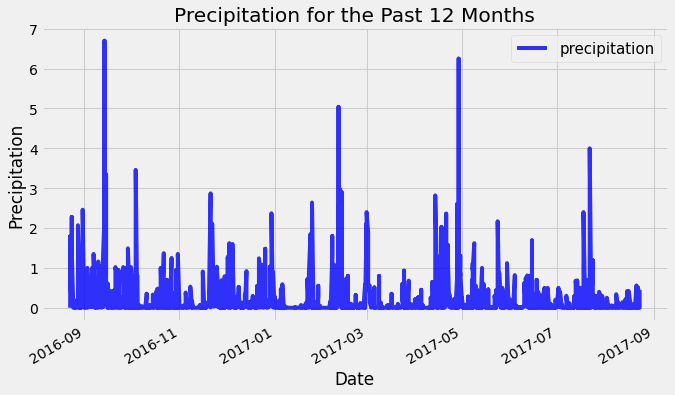

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= \
                                last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['date', 'precipitation'])

# deop the null values
df = df.dropna()

# Change datatype from element to datetime object on Pandas
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Set index to date
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation for the Past 12 Months", color='blue', alpha=0.8, figsize=(10,6))
plt.legend(prop={'size': 15})
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.savefig("Images/Precipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station.id).count()
print(f"Available Station Count: {count}")

Available Station Count: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
most_active_station = active_station[0][0]

results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station).all()

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature for {most_active_station}: {results[0][0]}")
print(f"Highest Tempeature for {most_active_station}: {results[0][1]}")
print(f"Average Tempeature for {most_active_station}: {results[0][2]}")

Most Active Station: USC00519281
Lowest Temperature for USC00519281: 54.0
Highest Tempeature for USC00519281: 85.0
Average Tempeature for USC00519281: 71.66378066378067


Highest number of temperature observations for the Station: USC00519281
The latest date available for USC00519281 : 2017-08-18
12 months back date for ('USC00519281',) : 2016-08-18 00:00:00


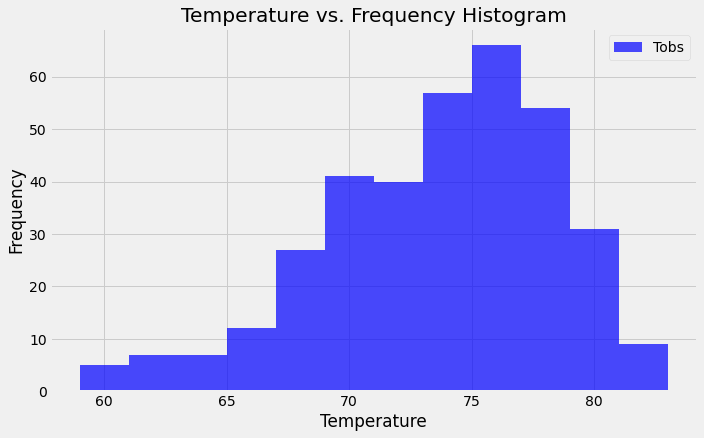

In [16]:
# Choose the station with the highest number of temperature observations.
highest_station = session.query(Measurement.station).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
print(f"Highest number of temperature observations for the Station: {highest_station[0]}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# find the latest date available for this stations
tob_date = session.query(Measurement.date).filter(Measurement.station == highest_station[0]).order_by(Measurement.date.desc()).first()[0]
print(f"The latest date available for {highest_station[0]} : {tob_date}")

tobs_last_year = dt.datetime.strptime(tob_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(f"12 months back date for {highest_station} : {tobs_last_year}")

highest_tobs_data = session.query( Measurement.tobs).filter(Measurement.date >= tobs_last_year).\
        filter(Measurement.station == highest_station[0]).all()

# put the data to a Panda's data frame
tobs_df = pd.DataFrame(highest_tobs_data, columns=['Tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
tobs_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram",color='blue', alpha=0.7, figsize=(10,6))
plt.tight_layout()
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("Images/TobsVSFrequency.png")
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
trip_start_date = '2012-02-28'
trip_end_date = '2012-03-05'
print(calc_temps(trip_start_date, trip_end_date))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_year_trip_start =  dt.datetime.strptime(trip_start_date, "%Y-%m-%d") - dt.timedelta(days=365)
last_year_trip_end =  dt.datetime.strptime(trip_end_date, "%Y-%m-%d") - dt.timedelta(days=365)

my_trip = calc_temps(last_year_trip_start, last_year_trip_end)
my_trip

[(61.0, 70.17021276595744, 75.0)]

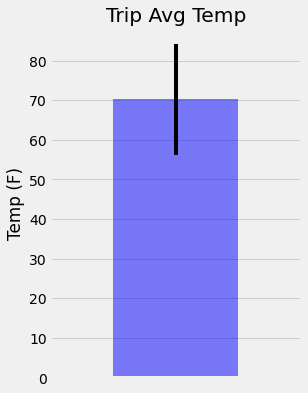

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(my_trip, columns=["tmin", "tavg", "tmax"])
yerr = trip_df["tmax"] - trip_df["tmin"]

trip_df.plot.bar(y='tavg', yerr=yerr, title='Trip Avg Temp', color='blue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

print(f"Previous Year Matching Dates are: {last_year_trip_start} and {last_year_trip_end}")
highest_prcp_data = session.query( \
        Measurement.station, Measurement.prcp, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= last_year_trip_start ).filter(Measurement.date <= last_year_trip_end).\
        group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

prcp_df = pd.DataFrame(highest_prcp_data, columns=['Station', 'PRCP', 'Latitude', 'Longitude', 'Elevation'])
prcp_df

Previous Year Matching Dates are: 2011-02-28 00:00:00 and 2011-03-06 00:00:00


,Station,PRCP,Latitude,Longitude,Elevation
0,USC00516128,0.22,21.33310,-157.80250,152.4
1,USC00519523,0.18,21.33556,-157.71139,19.5
2,USC00513117,0.14,21.42340,-157.80150,14.6
3,USC00519397,0.10,21.27160,-157.81680,3.0
4,USC00514830,0.05,21.52130,-157.83740,7.0
5,USC00519281,0.03,21.45167,-157.84889,32.9
6,USC00518838,0.02,21.49920,-158.01110,306.6
7,USC00511918,0.00,21.31520,-157.99920,0.9
8,USC00517948,NaN,21.39340,-157.97510,11.9


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(f"My trip Dates are: {trip_start_date} and {trip_end_date}")

# Use the start and end date to create a range of dates
#trip_range = np.arange(trip_start_date, trip_end_date)
trip_range = pd.date_range(start=trip_start_date,end=trip_end_date)

trip_normals =[]
# Stip off the year and save a list of %m-%d strings
for date in trip_range:
   # print(strftime("%m-%d", date))
    date_range = (date.strftime("%m-%d"))
    trip_normals.append(*daily_normals(date_range))

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals

My trip Dates are: 2012-02-28 and 2012-03-05


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_df = pd.DataFrame(trip_normals, columns=['tmin', 'tavg', 'tmax'])
#trip_df = pd.DataFrame(trip_normals)
trip_df

,tmin,tavg,tmax
0,65.0,70.655172,80.0
1,67.0,71.733333,79.0
2,64.0,70.032787,76.0
3,61.0,70.366667,78.0
4,60.0,70.068966,78.0
5,57.0,69.272727,77.0
6,60.0,67.890909,76.0


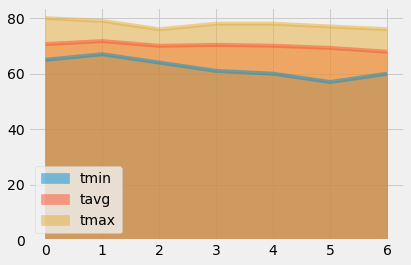

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False)